<a href="https://colab.research.google.com/github/BlueBerry-Coder/Practice/blob/main/Model3D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 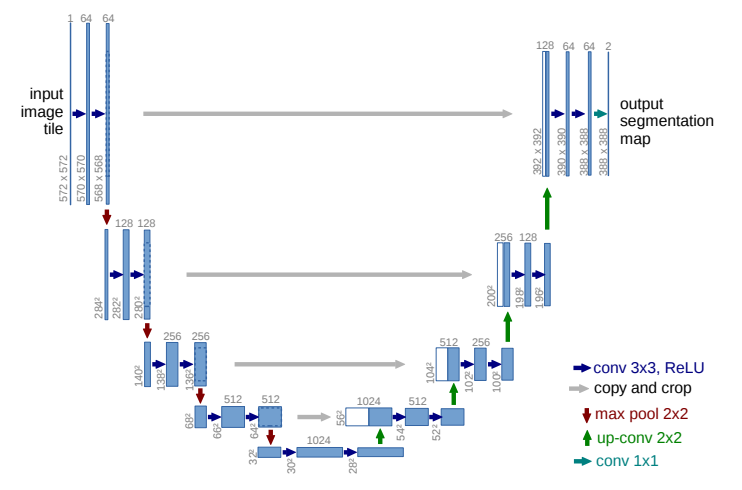

In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchsummary import summary

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, (3, 3, 3), (1, 1, 1), (1, 1, 1), bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, (3, 3, 3), (1, 1, 1), (1, 1, 1), bias=False),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)

        )

    def forward(self, x):
        return self.conv(x)

In [ ]:
class UNET3D(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[4, 8, 16, 32, 64, 128],
    ):
        super(UNET3D, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose3d(
                    feature * 2, feature, kernel_size=(2, 2, 2), stride=(2, 2, 2),
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=(1, 1, 1))

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            if x.shape != skip_connection.shape:
                x_flat = x.swapaxes(1, 2).flatten(0, 1)
                c = TF.resize(x_flat, skip_connection.shape[3:], antialias=True)
                x = c.view(*x.shape[:3], *c.shape[-2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        return self.final_conv(x)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
features = [4, 8, 16]
features_factor = [2**i for i in range(6)]
batch_size = [1, 4, 16]
height_width = [128, 224]

In [ ]:
configs = []
for h_w in height_width:
    for bs in batch_size:
        features = [4, 8, 16]
        while len(features)<6:
            for f in features_factor:
                feautures_i = [f*i for i in features]
                try:
                    x = torch.randn((bs, 1, 128, h_w, h_w)).to('cuda')
                    model = UNET3D(in_channels=1, out_channels=1, features=feautures_i).to('cuda')
                    preds = model(x)
                    par = count_parameters(model)
                    cfg = {
                    "features": feautures_i,
                    "depth": len(feautures_i),
                    "h_w": h_w,
                    "batch_size": bs,
                    "n_parameters": par
                    }
                    print(cfg)
                    configs.append(cfg)
                except Exception as e:
                    print(f"Out with error {e} \n cfg: {cfg}")
                finally:
                    pass

            features.append(features[-1]*2)

In [ ]:
import pandas as pd
df = pd.DataFrame(configs)
df.to_csv("acceptable_configs.csv")

In [ ]:
import seaborn as sns
import pandas as pd

configs_df = pd.read_csv("acceptable_configs.csv")

In [ ]:
configs_df

In [ ]:
g = sns.scatterplot(data=configs_df, x='n_parameters', y='batch_size', hue='h_w')#, hue='depth', palette="vlag")
g.set_yscale("log")
g.set_xscale("log")
_ = g.set(xlabel="Trainable parameters", ylabel="Batch size")

In [ ]:
if __name__ == "__main__":
    test()

64
Error: Out of memory!
